# Data Wrangling OpenStreetMap Data
## Introduction
In this notebook we will be tackling the process of retreiving map data from a source, OpenStreetMap, auditing it, parsing to from XML to JSON, and then loading it into MongoDB.

### The Map:
https://www.openstreetmap.org/export#map=13/30.1274/-97.8108
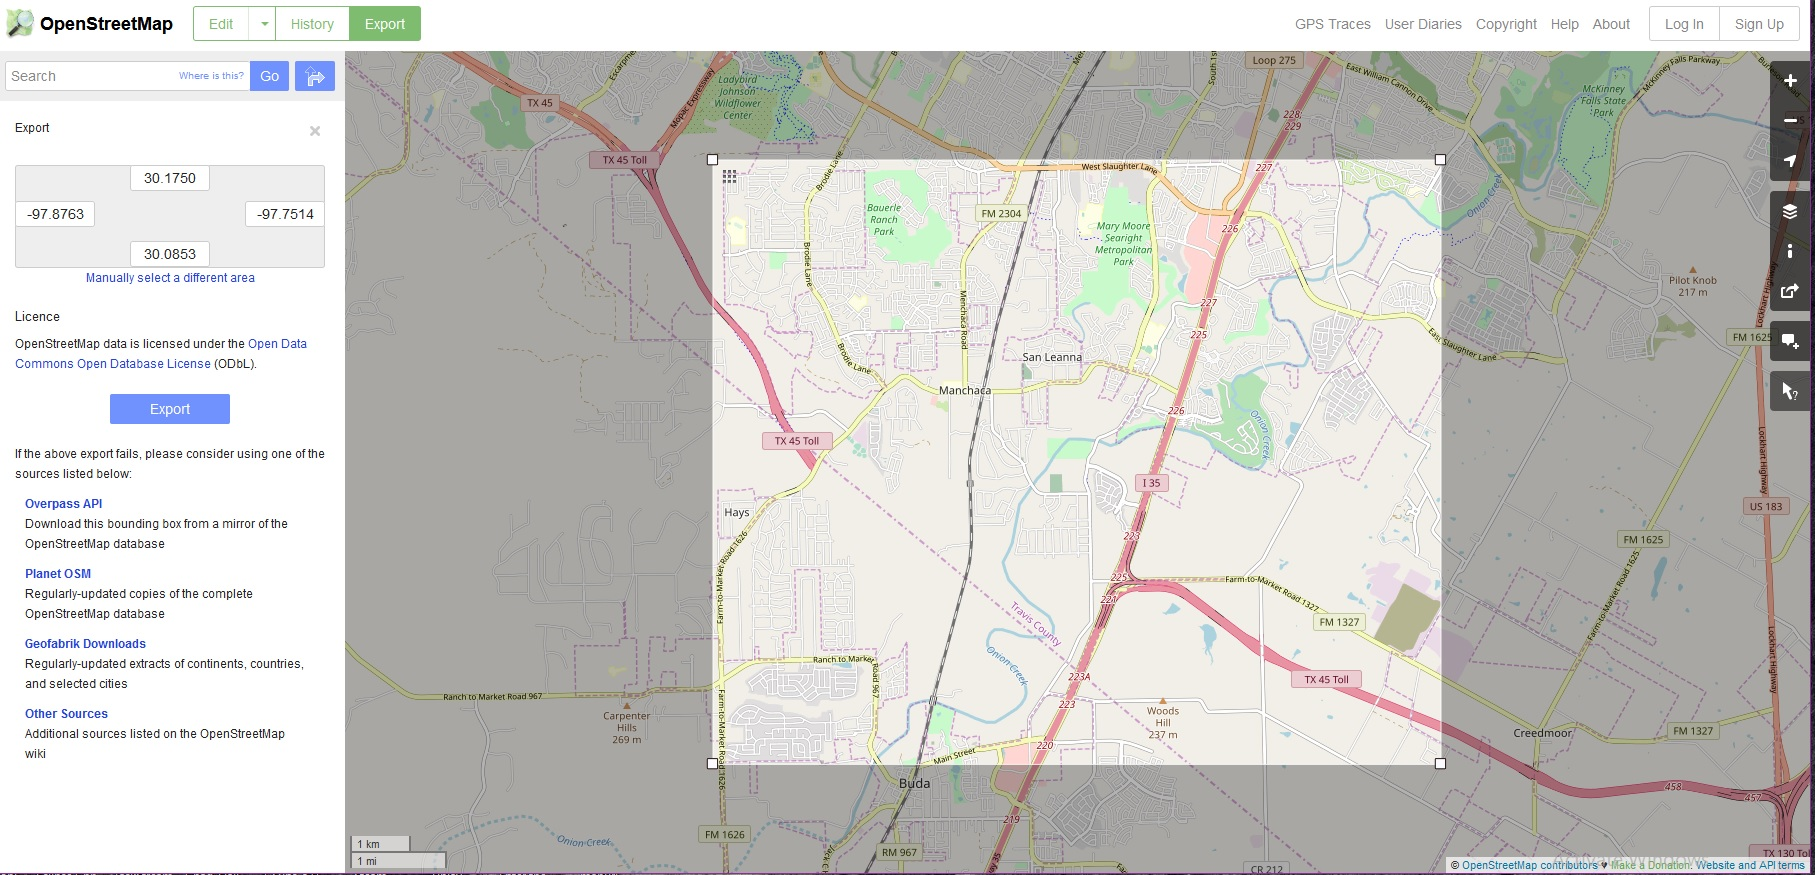

The reason I have chosen this area is because a few of my friends recently moved to this area. Since I know nothing of the area, I figured that it would be pretty neat to use it for this project. They moved to a neighborhood called 'Onion Creek', which is named after the creek that runs by it. From what I have looked up, it doesn't belong to any certain town or village inside of Austin, so I have tried to encompass a few that are adjacent to it.

This first step, since I already have the map downloaded, is to import various Python libraries that will be used in this project:

In [20]:
import DataWranglingFunctions as dw
import pprint
import dns
from collections import defaultdict, Counter
from pymongo import MongoClient

#### There are more libaries used, but they are imported with DataWranglingScript. 

#### A few  important tags and explanations:
 - node: Defines a point in space
 - relation: Describes the relations between two objects, such as a turn restriction or a route
 - tag: Describes meaning of the element they are attached to
 - way: Represents linear features
#### Later on, when we are transferring XML to JSON, we will be sorting into node and way.


In [22]:
osmfile = 'oncrknew.osm'

In [3]:
attr_counts = dw.count_att(osmfile)

print('Attributes and count in the OSM file: \n')
pprint.pprint(attr_counts)

Attributes and count in the OSM file: 

{'changeset': 311003,
 'generator': 1,
 'id': 311003,
 'k': 99773,
 'lat': 280901,
 'lon': 280901,
 'maxlat': 1,
 'maxlon': 1,
 'minlat': 1,
 'minlon': 1,
 'osm_base': 1,
 'ref': 319093,
 'role': 9128,
 'timestamp': 311003,
 'type': 9128,
 'uid': 311003,
 'user': 311003,
 'v': 99773,
 'version': 311004}


#### These attributes contain some of the key information about user inputs. The ones that we are most interested in are the 'k' tags, but before we continute I am interested in how many unique users have contributed to the data.

In [4]:
unique_users = dw.count_unique_users(osmfile)

print('Unique users who contributed to the data: \n')
pprint.pprint(unique_users)

Unique users who contributed to the data: 

421


#### Interesting, all of these entries from only 421 different users.
Now, lets go back to our data set and look at what the K values contain.

In [5]:
k_list = dw.k_count(osmfile)

kount = Counter(k_list)
high_count = kount.most_common(10)
for i in high_count:
    pprint.pprint((i[0],i[1]))

('building', 25839)
('height', 20883)
('addr:street', 14705)
('addr:housenumber', 14704)
('highway', 4092)
('addr:postcode', 3067)
('name', 1847)
('tiger:cfcc', 907)
('tiger:county', 907)
('tiger:name_base', 869)


### I chose to supress the main output, and we only view the top k values.

#### There seem to be quite a few tags with some strange characters that maybe should not go to the JSON file. We will write a function to make sure they do not make it into the JSON.
#### One thing that I had noticed after checking out the OSM file is that there are some tags that say 'tiger:'. These seem to contain info that is already in the entry.

In [6]:
problem_characters = dw.prob_char(osmfile)
print('Count of problem characters in K tags: \n')
pprint.pprint(problem_characters)

Count of problem characters in K tags: 

{'lower': 58716,
 'lower_colon': 40614,
 'other': 233,
 'problemchars': 0,
 'tiger': 210}


#### Interestingly enough, after trying this a few time, there are over 7000 'tiger:' characters. finding the lowercase colon strings reduces about 7000 of them down.

From looking at the OSM file file, I have noticed that there are inconsistant street names. Let's take a look at that and see what we can find.
We will start by using some street types that I am familiar with, then audit the list after we have more information regarding local naming habits.

The 'expected' list is going to allow us to return values that do not match what we 'expected' the names to be.

After running the function once, I added more expected street names for the final output.

In [7]:
print('Irregular Streets:')
ireg_str = dw.audit_street_names(osmfile)
pprint.pprint(dict(ireg_str))

Irregular Streets:
{'1327': {'Farm-to-Market Road 1327', 'FM 1327'},
 '150': {'S Ih 35 # 150'},
 '1626': {'FM 1626', 'F.M. 1626', 'Farm-to-Market Road 1626'},
 '35': {'S Interstate 35', 'South I 35', 'I 35', 'S IH 35'},
 'B': {'South Interstate 35, Suite B'},
 'C-200': {'9600 IH 35 C-200'},
 'Ct': {'Sweetgum Ct'},
 'Cv': {'Mock Cherry Cv',
        'Morning Primrose Cv',
        'Salem Oak Cv',
        'Texas Ash Cv'},
 'Dr': {'Bill Baker Dr', 'Dave Silk Dr'},
 'Ln': {'Buzz Schneider Ln', 'Chick Pea Ln'},
 'Rd': {'Tawny Farms Rd'},
 'street': {'South 1st street'}}


#### Now that we have cut that list down, I can make a dictionary and a function that will allow me to change the names as they go into the JSON file.

### Phone Numbers
Something that I noticed while looking for phone numbers throughout the XML file is that they are not very consistant. Some of them contain dashes, international number markers, and spaces. I want to make them more consistant for the JSON file, so I will make them all the same format.

In [8]:
phones = dw.count_phones(osmfile)
print('Total count of phone numbers:', phones)

Total count of phone numbers: 72


In [9]:
list_of_phones = dw.print_phones(osmfile)
pprint.pprint(list_of_phones)

['5122821326',
 '5122821326',
 '+1-512-280-8922',
 '+1-512-280-8922',
 '+1 512 295 8166',
 '+1 512 295 8166',
 '(512) 295-0247',
 '(512) 295-0247',
 '+1 512 312 2383',
 '+1 512 312 2383',
 '+1 512 282 2011',
 '+1 512 282 2011',
 '(512) 312-0907',
 '(512) 312-0907',
 '5122915050',
 '5122915050',
 '+1 512 282 2697',
 '+1 512 282 2697',
 '+1 512 312 2140',
 '+1 512 312 2140',
 '+1 512 295 1687',
 '+1 512 295 1687',
 '+1 512 295 1687',
 '+1 512 295 1687',
 '+1 512 295 1687',
 '+1 512 295 1687',
 '512-712-5661',
 '512-712-5661',
 '5125413823',
 '5125413823',
 '512-291-8222',
 '512-291-8222',
 '(512) 292-1093',
 '(512) 292-1093',
 '(512) 961-1834',
 '(512) 961-1834',
 '(512) 416-6000',
 '(512) 416-6000',
 '+1-512-292-7848',
 '+1-512-292-7848',
 '+1 512-888-9223',
 '+1 512-888-9223',
 '+1-512-292-6973',
 '+1-512-292-6973',
 '(512) 292-9357',
 '(512) 292-9357',
 '+1-512-295-1670',
 '+1-512-295-1670',
 '(512) 312-1615',
 '(512) 312-1615',
 '(512) 295-7286',
 '(512) 295-7286',
 '+1 512 295 2188'

### A function is then created to change the phone numbers to the same format.

In [10]:
dw.process_map(osmfile, pretty = False);
print('JSON File Created')

JSON File Created


## The JSON file is now created
I chose to supress the output, since it is a very long run of dictionaries.
Each node now has this format:

> {
"id": "2406124091",
"type: "node",
"visible":"true",
"created": {
          "version":"2",
          "changeset":"17206049",
          "timestamp":"2013-08-03T16:43:42Z",
          "user":"linuxUser16",
          "uid":"1219059"
        },
"pos": [41.9757030, -87.6921867],
"address": {
          "housenumber": "5157",
          "postcode": "60625",
          "street": "North Lincoln Ave"
        },
"amenity": "restaurant",
"cuisine": "mexican",
"name": "La Cabana De Don Luis",
"phone": "1 (773)-271-5176"
}

#### The JSON file as been uploaded to MongoDB Atlas, and now we will utilize PyMongo to query the database.

In [12]:
client = MongoClient('mongodb+srv://<username>:<pass>@cluster0-66blm.mongodb.net/test?retryWrites=true&w=majority')

#### This has connected us to the database, we can now name our variables for querying

In [13]:
db = client.UDClassExtr
collection = db.Austin

#### Let's find out how may node and way tags are contained in the database:

In [14]:
collection.count_documents({'type':'node'})

280901

In [15]:
collection.count_documents({'type':'way'})

29971

#### How many neighbourhoods? What are their names?

In [16]:
collection.count_documents({'place':'neighbourhood'})

19

In [17]:
for col in collection.find({'place':'neighbourhood'},{'_id': 0, 'name': 1}):
    pprint.pprint(col)

{'name': 'Tanglewood Forest'}
{'name': 'Shady Hollow'}
{'name': 'Ford Oaks'}
{'name': 'South Bend'}
{'name': 'Stone Creek Ranch'}
{'name': 'Crossings at Onion Creek'}
{'name': 'Perkins Valley'}
{'name': 'Southpark Meadows'}
{'name': 'Park Ridge'}
{'name': 'Saddlewood Estates'}
{'name': 'Bauerle Ranch'}
{'name': 'Bluff Springs Estates'}
{'name': 'Stablewood at Slaughter Creek'}
{'name': 'Meadows at Double Creek'}
{'name': 'Ashbrook'}
{'name': 'Olympic Heights'}
{'name': 'Hillcrest'}
{'name': 'Canterbury Trails'}
{'name': 'Searight Village'}


### How many restuarants are in the area, and what are their names and locations?

In [18]:
collection.count_documents({'amenity':'restaurant'})

7

In [19]:
for col in collection.find({'amenity':'restaurant'},{'_id': 0, 'name': 1, 'address': 1}):
    pprint.pprint(col)

{'name': 'Bill Miller Bar-BQ'}
{'address': {'housenumber': '9300', 'street': 'South I-35 Service SB'},
 'name': 'Thai Passion - South'}
{'address': {'housenumber': '1671', 'street': 'Main Street'},
 'name': 'IM Thai Cuisine Buda'}
{'name': 'Pizza Hut'}
{'address': {'city': 'Buda', 'housenumber': '824', 'street': 'Main Street'},
 'name': "Willie's Joint BBQ"}
{'address': {'housenumber': '9500', 'street': 'Interstate 35 Frontage Road'},
 'name': 'Serranos Cocina y Cantina'}
{'name': 'Bill Miller Bar-B-Q'}


#### There were a few duplicates, with further auditing those could be removed.

Thoughts on the dataset

I think that the OSM dataset would benefit from more validation and QC when the users are inputting entries into the system. For example, the phone number listings should have a standardized format. Possibley, they could find some way to keep the 'tiger:' entries from being present. I know that this can be a very big issue when it comes to user generated data.

The dataset would also benefit from a validation system to weed out duplicate entries before they make it into the system.


### References
- Pymongo Commands: http://zetcode.com/python/pymongo/
- Markdown for Jupyter: https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed
- https://docs.python.org/3/library/re.html
- https://effbot.org/zone/celementtree.html
- https://wiki.openstreetmap.org/wiki/Main_Page